# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

#### New notebook

This notebook was forked from [this](https://github.com/cdthompson/deepracer-k1999-race-lines/blob/master/Race-Line-Calculation.ipynb) notebook by cdthompson.

This repo only contains the new notebook, not the entire directory. So make sure to download the entire directory from cdthompson's repo.

In [25]:
import glob
import numpy as np
import shapely
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
from tabulate import tabulate
import sys
import helpers

##  Versions

In [26]:
versions = {
    'numpy': np.__version__,
    'shapely': shapely.__version__,
    'panda': pd.__version__,
    'matplotlib': matplotlib._get_version(),
    'helpers': helpers.__version__,
    'python': sys.version
}

table = tabulate(
    versions.items(),
    headers=["Module", "Version"],
    tablefmt="fancy_grid",
)

print(table)

╒════════════╤═══════════════════════════════════════════════════╕
│ Module     │ Version                                           │
╞════════════╪═══════════════════════════════════════════════════╡
│ numpy      │ 1.23.5                                            │
├────────────┼───────────────────────────────────────────────────┤
│ shapely    │ 1.8.4                                             │
├────────────┼───────────────────────────────────────────────────┤
│ panda      │ 1.5.3                                             │
├────────────┼───────────────────────────────────────────────────┤
│ matplotlib │ 3.7.1                                             │
├────────────┼───────────────────────────────────────────────────┤
│ helpers    │ 0.0.1                                             │
├────────────┼───────────────────────────────────────────────────┤
│ python     │ 3.10.9 (main, Mar  8 2023, 10:47:38) [GCC 11.2.0] │
╘════════════╧════════════════════════════════════════════════

## Global Variables

In [27]:
GLOBAL_VARS = {
    'TRACKS_DIR': "../data/tracks",
    'RACEPACK_DIR': "../data/racepack",
    'REWARD_FUNCTION': "../reward_functions/_template/reward_function.py",
    'NOTEBOOK': "DeepRacer.ipynb"
}

## Load the track to analyze

In [28]:
from helpers.utilities import load_available_tracks

df_available_tracks = load_available_tracks(GLOBAL_VARS['TRACKS_DIR'])

# Store TRACK LIBRARY in GLOBALS
GLOBAL_VARS["TRACK_LIBRARY"] = df_available_tracks

print(df_available_tracks['file_name'].head(200))

0           2022_april_open
1       2022_april_open_ccw
2        2022_april_open_cw
3            2022_april_pro
4        2022_april_pro_ccw
               ...         
121           reinvent_wood
122       thunder_hill_open
123        thunder_hill_pro
124    thunder_hill_pro_ccw
125     thunder_hill_pro_cw
Name: file_name, Length: 126, dtype: object


In [29]:
TRACK_VARS = {
    'TRACK_NAME_SEARCH': 'wide',
    'TRACK_INDEX': None,
    'TRACK_FILE_NAME': None,
    'TRACK_FILE_PATH': None,
    'TRACK_WAYPOINTS': None,
    'TRACK_REDUCED_WAYPOINTS': None,
    'TRACK_SHAPELY': None,
    'TRACK_REDUCED_SHAPELY': None,
    'TRACK_FIGURE': None,
    'TRACK_FIGURE_OVERLAY': None,
    'TRACK_IS_LOOP_RING': None,
    'TRACK_REDUCED_IS_LOOP_RING': None,
    'TRACK_REDUCE_PERC': 0.8
}

In [30]:
from helpers.utilities import search_track_files

df_track_search, success = search_track_files(GLOBAL_VARS['TRACK_LIBRARY'], TRACK_VARS['TRACK_NAME_SEARCH'])
print(df_track_search)

                      file_name                                      file_path
109           reInvent2019_wide           ../data/tracks/reInvent2019_wide.npy
110       reInvent2019_wide_ccw       ../data/tracks/reInvent2019_wide_ccw.npy
111        reInvent2019_wide_cw        ../data/tracks/reInvent2019_wide_cw.npy
112  reInvent2019_wide_mirrored  ../data/tracks/reInvent2019_wide_mirrored.npy


## Set Track Details

### Select Track

In [31]:
TRACK_VARS['TRACK_INDEX'] = 110
TRACK_VARS['TRACK_FILE_NAME'] = 'reInvent2019_wide_ccw'
TRACK_VARS['TRACK_FILE_PATH'] = '../data/tracks/reInvent2019_wide_ccw.npy'

In [32]:
from helpers.utilities.load import load_track_waypoints

TRACK_VARS['TRACK_WAYPOINTS'] = load_track_waypoints(TRACK_VARS['TRACK_FILE_PATH'])

loop/ring: True


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


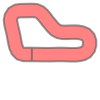

In [33]:
from helpers.utilities import convert_to_shapely

TRACK_VARS['TRACK_SHAPELY'] = convert_to_shapely(TRACK_VARS['TRACK_WAYPOINTS'])
TRACK_VARS['TRACK_IS_LOOP_RING'] = TRACK_VARS['TRACK_SHAPELY']['l_center_line'].is_ring
print(f"loop/ring: {TRACK_VARS['TRACK_IS_LOOP_RING']}")
TRACK_VARS['TRACK_SHAPELY']['road_poly']

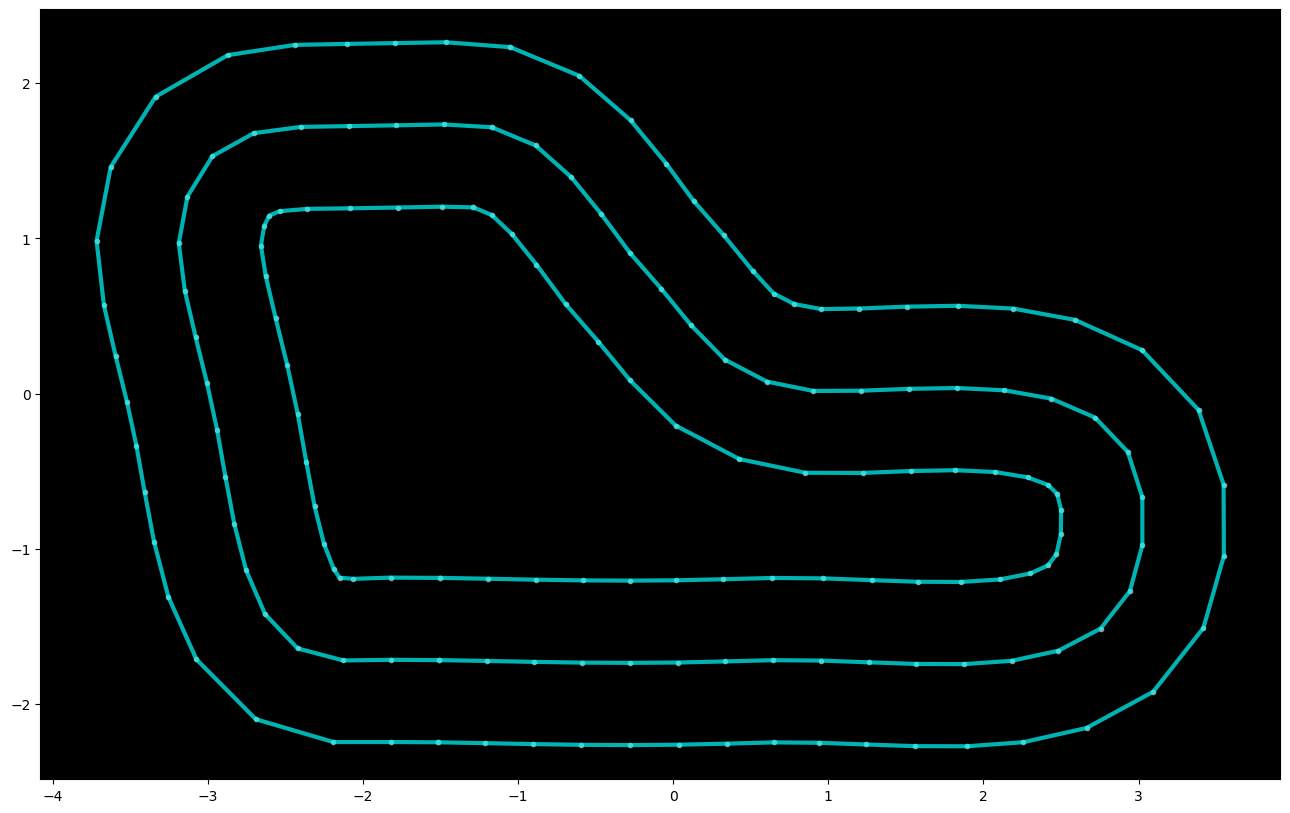

In [34]:
# Show plot of original track

from helpers.utilities import print_border

TRACK_VARS['TRACK_FIGURE'] = plt.figure(1, figsize=(16, 10))
ax = TRACK_VARS['TRACK_FIGURE'].add_subplot(111, facecolor='black')
plt.axis('equal')

print_border(
    ax,
    TRACK_VARS['TRACK_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

## Reduce width of track

loop/ring: True


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


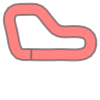

In [35]:
from helpers.utilities import x_perc_width

TRACK_VARS['TRACK_REDUCE_PERC'] = .8

reduce_waypoints = [x_perc_width(waypoint, perc_width=TRACK_VARS['TRACK_REDUCE_PERC']) for waypoint in TRACK_VARS['TRACK_WAYPOINTS']]
TRACK_VARS['TRACK_REDUCED_WAYPOINTS'] = np.asarray(reduce_waypoints)

TRACK_VARS['TRACK_REDUCED_SHAPELY'] = convert_to_shapely(TRACK_VARS['TRACK_REDUCED_WAYPOINTS'])
TRACK_VARS['TRACK_REDUCED_IS_LOOP_RING'] = TRACK_VARS['TRACK_REDUCED_SHAPELY']['l_center_line'].is_ring
print(f"loop/ring: {TRACK_VARS['TRACK_REDUCED_IS_LOOP_RING']}")
TRACK_VARS['TRACK_REDUCED_SHAPELY']['road_poly']

# Display the original track waypoints

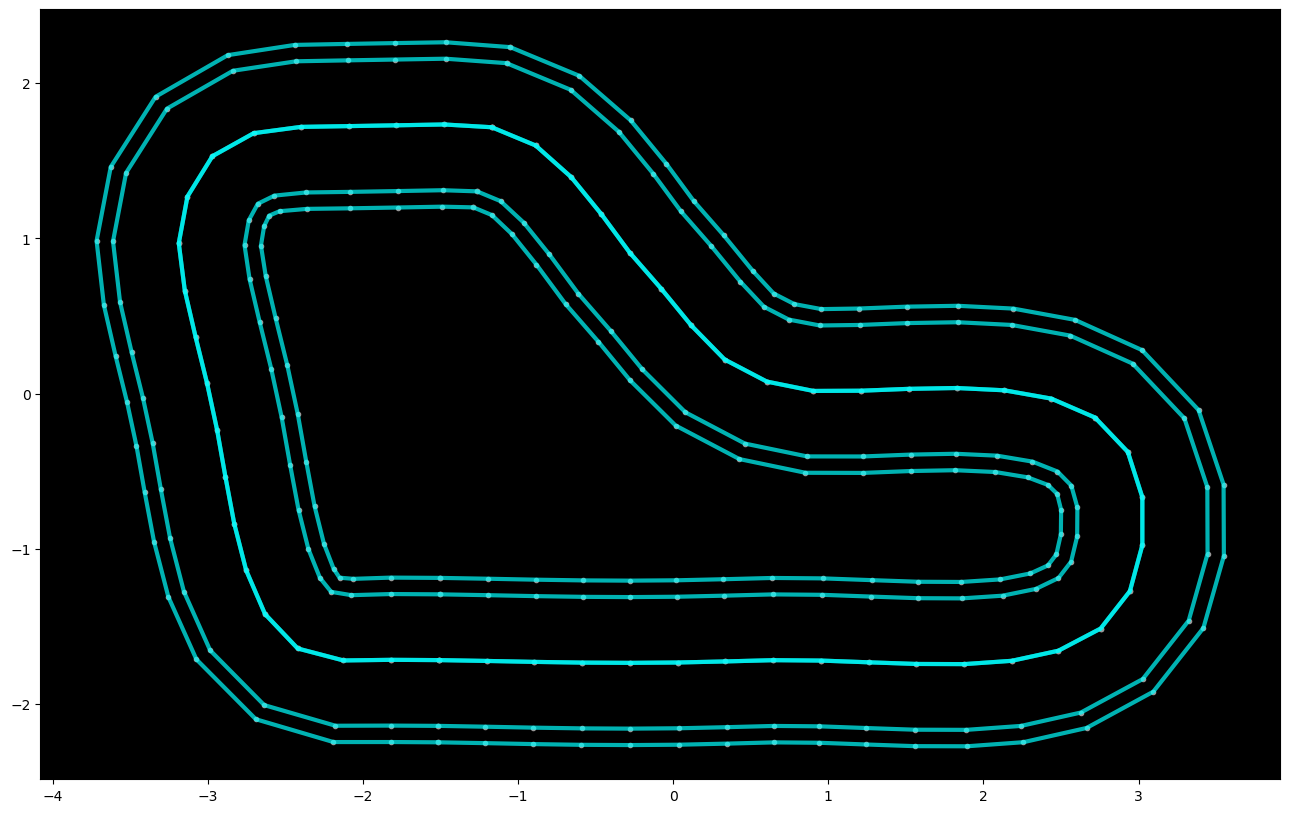

In [36]:
from helpers.utilities import print_border

TRACK_VARS['TRACK_FIGURE_OVERLAY'] = plt.figure(1, figsize=(16, 10))
ax = TRACK_VARS['TRACK_FIGURE_OVERLAY'].add_subplot(111, facecolor='black')
plt.axis('equal')

print_border(
    ax,
    TRACK_VARS['TRACK_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

# Also print new border
print_border(
    ax,
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['center_line'],
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_REDUCED_SHAPELY']['outer_border']
)

## Calculate the race line!

In [37]:
RACE_LINE_VARS = {
    'RACE_LINE_SAVE_DIR': '../data/racelines',
    'RACE_LINE_XI_ITERATIONS': 8,  # Number of times to iterate each new race line point, keep this at 3-8 for best balance of performance and desired result
    'RACE_LINE_LINE_ITERATIONS': 1500 , # Number of times to scan the entire race track to iterate, 500 will get a good start, 1500 will be closer to optimal result
    'RACE_LINE_LENGTH_ORIGINAL': TRACK_VARS['TRACK_SHAPELY']['l_center_line'].length,
    'RACE_LINE_ADDED_CLOSE_LOOP_WAYPOINT': None,
    'RACE_LINE_IMPROVED': None,
    'RACE_LINE_IMPROVED_FIG': None,
    'RACE_LINE_IMPROVED_LENGTH': None
}

In [ ]:
from helpers.utilities import improve_race_line_runner

RACE_LINE_VARS['RACE_LINE_IMPROVED'] = improve_race_line_runner(
    TRACK_VARS['TRACK_REDUCED_SHAPELY'],
    RACE_LINE_VARS['RACE_LINE_LINE_ITERATIONS'],
    RACE_LINE_VARS['RACE_LINE_XI_ITERATIONS']
)

56


/home/jmagady.fam@ad.recitsols.com/Development/repositories/github/bohica-labs/DeepRacer/NoteBooks/helpers/utilities/curve.py:39: RuntimeWarning: invalid value encountered in double_scalars
  theta = np.arccos(np.dot(vec21, vec23) / (norm21 * norm23))
/home/jmagady.fam@ad.recitsols.com/Development/repositories/github/bohica-labs/DeepRacer/NoteBooks/helpers/utilities/curve.py:39: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(vec21, vec23) / (norm21 * norm23))


In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'] = np.append(RACE_LINE_VARS['RACE_LINE_IMPROVED'], [RACE_LINE_VARS['RACE_LINE_IMPROVED'][0]], axis=0)
RACE_LINE_VARS['RACE_LINE_ADDED_CLOSE_LOOP_WAYPOINT'] = True
RACE_LINE_VARS['RACE_LINE_IMPROVED_LENGTH'] = LineString(RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE']).length



# These should be the same
print("These should be the same: ", (TRACK_VARS['TRACK_SHAPELY']['center_line'].shape, RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'].shape))
print("Original centerline length: %0.2f" % RACE_LINE_VARS['RACE_LINE_LENGTH_ORIGINAL'])
print("New race line length: %0.2f" % RACE_LINE_VARS['RACE_LINE_IMPROVED_LENGTH'])

RACE_LINE_VARS['RACE_LINE_IMPROVED_FIG'] = plt.figure(1, figsize=(16, 10))
ax = RACE_LINE_VARS['RACE_LINE_IMPROVED_FIG'].add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(
    ax,
    RACE_LINE_VARS['RACE_LINE_IMPROVED_LOOP_RACE_LINE'],
    TRACK_VARS['TRACK_SHAPELY']['inner_border'],
    TRACK_VARS['TRACK_SHAPELY']['outer_border']
)

# Also print new border
#print_border(ax, loop_race_line, inner_border_new, outer_border_new)

## Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [ ]:
RACE_PACKAGE = {
    'VERSIONS': versions,
    'GLOBAL_VARS': GLOBAL_VARS,
    'TRACK_VARS': TRACK_VARS,
    'RACE_LINE_VARS': RACE_LINE_VARS
}

In [ ]:
from helpers.utilities import save_racepack

save_racepack(RACE_PACKAGE)

# Load save racepack package

In [ ]:
TRACK_NAME = # example: "reInvent2019_wide_ccw"
PACKAGE_NAME = # example: "467605c5-ecf4-40b1-8370-71199e6f7e96_20230317_013017"
PACKAGE_LOCATION = f"../data/racepack/{TRACK_NAME}/{PACKAGE_NAME}/package.racepack.pickle.gz"

In [ ]:
from helpers.utilities import load_package

loaded_racepack = load_package(PACKAGE_LOCATION)

In [24]:
loaded_racepack["RACE_LINE_VARS"]["RACE_LINE_IMPROVED_FIG"].savefig("fig.png")